Taken from: https://math.stackexchange.com/questions/2013050/log-of-softmax-function-derivative

The derivation of the softmax score function (aka eligibility vector) is as follows:  
  
First, note that:  
#### $$\pi_\theta(s,a) = softmax =\frac{e^{\phi(s,a)^\intercal\theta}}{\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta}}$$  
The important bit here is that the slide only identifies the proportionality, not the full softmax function which requires the normalization factor.  
  
Continuing the derivation:  
  
Using the log identity $\log(x/y) = \log(x) - \log(y)$ we can write  
#### $$\log(\pi_\theta(s,a)) = \log(e^{\phi(s,a)^\intercal\theta}) - \log(\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta})$$  
  
Now take the gradient:  
#### $$\nabla_\theta\log(\pi_\theta(s,a)) = \nabla_\theta\log(e^{\phi(s,a)^\intercal\theta}) - \nabla_\theta\log(\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta})$$  
  
The left term simplifies as follows:  
  
#### $$left= \nabla_\theta\log(e^{\phi(s,a)^\intercal\theta}) = \nabla_\theta\phi(s,a)^\intercal\theta = \phi(s,a)$$
  
The right term simplifies as follows:  
  
Using the chain rule:  
#### $$\nabla_x\log(f(x)) = \frac{\nabla_xf(x)}{f(x)}$$
  
We can write:  
  
#### $$right = \nabla_\theta\log(\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta}) = \frac{\nabla_\theta\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta}}{\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta}}$$  

Taking the gradient of the numerator we get:  
  
#### $$right = \frac{\sum_{k=1}^N{\phi(s,a_k)}e^{\phi(s,a_k)^\intercal\theta}}{\sum_{k=1}^Ne^{\phi(s,a_k)^\intercal\theta}}$$
Substituting the definition of $\pi_\theta(s,a)$ we can simplify to:  
  
#### $$right = \sum_{k=1}^N{\phi(s,a_k)}\pi_\theta(s,a_k)$$  
Given the definition of Expected Value:  
  
#### $$\mathrm{E}[X] = X \cdot P = x_1p_1+x_2p_2+ ... +x_np_n$$
Which in English is just the sum of each feature times its probability.  
  
####$$X = features = {\phi(s,a)}$$  
####$$P = probabilities =\pi_\theta(s,a)$$  
So now we can write the expected value of the features:  
  
#### $$right = \mathrm{E}_{\pi_\theta}[\phi(s,\cdot)]$$  
Putting it all together:  
#### $$\nabla_\theta\log(\pi_\theta(s,a)) = left - right = \phi(s,a) - \mathrm{E}_{\pi_\theta}[\phi(s,\cdot)]$$

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import gym as gym
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
from IPython import display
import cv2 as cv2
import random
import tensorflow.contrib.eager as tfe
import tensorflow as tf
tf.enable_eager_execution()
%matplotlib inline

from utils.plotting import RewardHistory


/home/william/anaconda3/envs/deeprlbootcamp/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


# An agent that samples randomly generated weights until it can do 200 episodes

In [ ]:
class RandomAgent():
    def __init__(self):
        self._weights = np.random.uniform(-1, 1, 4)
        self.env = gym.make('CartPole-v0')
        
    def get_action(self, s):
        result = np.matmul(self._weights, s)
        if result > 0:
            return 1
        else:
            return 0
    def randomize(self):
        self._weights = np.random.uniform(-1, 1, 4)
    
    def train(self, episodes=1):
        for episode in range(episodes):
            s = self.env.reset()
            steps = 0
            solved = False
            self.randomize() # randomize weights for each episode
            while True:
                action = self.get_action(s)
                s, reward, done, info = self.env.step(action)
                steps += 1
                if steps == 200:
                    solved = True
                if done:
                    print("Episode finished after {} timesteps".format(steps))
                    break
            if solved == True:
                print("Solved")
                break;
    
    def run(self):
        self.env = gym.make('CartPole-v0')
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.get_action(s)
            s, reward, done, info = self.env.step(action)
            steps += 1
            if done:
                print("Episode finished after {} timesteps".format(steps))
                break
        self.env.close()

agent = RandomAgent()
agent.train(2)

In [ ]:
agent.run()

# Policy Gradient  - raw with np only

In [421]:
class Agent():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.episode_durations = []
        self.episode_loss = []
        self.theta = np.random.randn(2, 4)
        self.learning_rate = 0.1
        
        
    def getAction(self, s):
        action_prob = self.softmax(self.theta.dot(s))
        action = np.random.choice([0, 1], p=action_prob)
        return action
    
    def softmax(self, x):
        top = np.exp(x)
        bottom = top.sum()
        return top/bottom
    
    def train(self, episodes=2, display=None):
        # Store cumulative returns for each time step
        all_returns = [[] for _ in range(200)]
        
        for i in range(episodes):
            s = self.env.reset()
            steps = 0
            s_mem = []
            a_mem = []
            r_mem = []
            
            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
                s_mem.append(s)
                a_mem.append(action)
                r_mem.append(reward)
                
                s = s_1
                
                steps += 1
                if done:
#                     print("Episode finished succe/ssfully after {} timesteps".format(steps))
                    break
            
            R = 0.
            grad = np.zeros_like(self.theta)
            for t in reversed(range(len(s_mem))):
                s_t = s_mem[t]
                a_t = a_mem[t]
                r_t = r_mem[t]
                R = 0.9 * R + r_t
                all_returns[t].append(R)
                if len(all_returns[t]) > 0:
                    b_t = np.mean(all_returns[t])
                
                a = np.zeros(self.theta.shape[0])
                a[a_t] = 1
                p = self.softmax(self.theta.dot(s_t))
                gradient = np.outer(a - p, s_t)
                gradient = gradient * (R - b_t)
                
                grad += gradient
                
#             grad = grad / (np.linalg.norm(grad) + 1e-8)
            self.theta += self.learning_rate * grad
            
            self.episode_durations.append(steps)
    
    def run(self):
        self.env = gym.make('CartPole-v0')
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()

agent = Agent()

def show_chart(agent):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(agent.episode_durations)
    plt.subplot(1, 2, 2)
    plt.xlabel('Last x Training Cycles')
    plt.ylabel('Loss')
    plt.plot(list(agent.episode_loss))
    plt.show()

# %time agent.train(episodes=2, display=show_chart)
# %time agent.train(episodes=100)
# show_chart(agent)
# plt.plot(agent.episode_durations)

# learner.train(1)

reward_history = RewardHistory()
for i in range(100):
    agent = Agent()
    agent.train(100)
    reward_history.append(agent.episode_durations)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

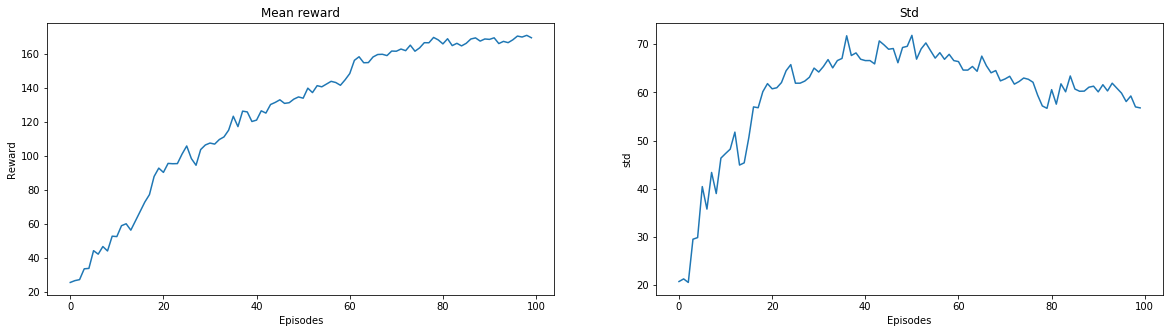

In [422]:
reward_history.plot()

In [345]:
agent.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode finished successfully after 200 timesteps


# Policy Gradient with a model

In [16]:
tf.log([[0.5, 0.5], [0.2, 0.8]])

<tf.Tensor: id=14497853, shape=(2, 2), dtype=float32, numpy=
array([[-0.6931472 , -0.6931472 ],
       [-1.609438  , -0.22314353]], dtype=float32)>

In [94]:
# import tensorflow.contrib.eager as tfe

class LinearModel(tf.keras.Model):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=2)
        self.dense2 = tf.keras.layers.Dense(units=2)

    def call(self, input):
        """Run the model."""
        result = self.dense1(input)
#         result = self.dense2(result)
        return result
    
    def eval(self, inputs):
        return tf.nn.softmax(self(inputs))
    
    
    def loss(self, inputs, targets):
        y = self(inputs)
    #     print(tf.squeeze(y))
        y = tf.nn.softmax(y)
#         print("Y:", y)
#         print("targets:", targets)
#         idx = tf.stack([tf.range(targets.shape[0]), targets], axis=1)
#         print("idx:", idx)
#         selected_action = tf.gather_nd(y, idx)
#         print("selected_action:", selected_action)
    #     print(tf.squeeze(targets))
#         print("YYYYYYYYYYYYYYYyy")
#         loss = tf.cast(targets, dtype="float32") - y
        loss = y * tf.cast(targets, dtype="float32")
        loss = tf.reduce_sum(loss, reduction_indices=1)
        loss = tf.log(loss)
#         return loss
#         loss = tf.losses.softmax_cross_entropy(onehot_labels=targets, logits=y)
#         print("Loss wx", loss)
        return loss
#         return tf.log(tf.nn.softmax(y))
#         return tf.nn.softmax(y)
#         return selected_action

    def grad(self, inputs, targets, reward):
        with tfe.GradientTape() as tape:
            loss_value = - tf.reduce_mean(self.loss(inputs, targets) * reward)
        return tape.gradient(loss_value, self.variables)

model = LinearModel()
# model.summary()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

reward = tf.constant([5., 5., 5.])
reward = tf.expand_dims(reward, axis=1)
print("reward:", reward)

result = model.eval(batch)
print("result:", result)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

# keep results for plotting
train_loss_results = []
train_accuracy_results = []
epoch_loss_avg = tfe.metrics.Mean()
epoch_accuracy = tfe.metrics.Accuracy()

num_epochs = 50

for epoch in range(num_epochs):

#     y = tf.constant([[0], [1]], dtype="int32")
    y = tf.one_hot([0, 1, 1], depth=2, dtype="int32")
#     y = tf.constant([1, 0, 1], dtype="int32")

    # Optimize the model
    grads = model.grad(batch, y, reward)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(model.loss(batch, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(batch), axis=1, output_type=tf.int32), tf.argmax(y, axis=1, output_type=tf.int32))

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 5 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
        
model.eval(batch)

batch: tf.Tensor(
[[0.94442344 0.36073625 0.11982799 0.78239477]
 [0.5427848  0.96488166 0.05322695 0.8631586 ]
 [0.6800004  0.790504   0.29929018 0.50455713]], shape=(3, 4), dtype=float32)
reward: tf.Tensor(
[[5.]
 [5.]
 [5.]], shape=(3, 1), dtype=float32)
result: tf.Tensor(
[[0.367998   0.632002  ]
 [0.35392714 0.6460729 ]
 [0.4581458  0.5418542 ]], shape=(3, 2), dtype=float32)
Epoch 000: Loss: -0.677, Accuracy: 66.667%
Epoch 005: Loss: -0.665, Accuracy: 66.667%
Epoch 010: Loss: -0.654, Accuracy: 66.667%
Epoch 015: Loss: -0.642, Accuracy: 66.667%
Epoch 020: Loss: -0.631, Accuracy: 66.667%
Epoch 025: Loss: -0.621, Accuracy: 66.667%
Epoch 030: Loss: -0.610, Accuracy: 66.667%
Epoch 035: Loss: -0.600, Accuracy: 66.667%
Epoch 040: Loss: -0.589, Accuracy: 66.667%
Epoch 045: Loss: -0.579, Accuracy: 66.667%


<tf.Tensor: id=29093616, shape=(3, 2), dtype=float32, numpy=
array([[0.46500835, 0.53499174],
       [0.257774  , 0.74222594],
       [0.30688107, 0.6931189 ]], dtype=float32)>

In [12]:
Transition = namedtuple("Transition", ["s", "a", "r"])

class PolicyGradientMemory():
    def __init__(self, gamma = 0.9):
        self.memory = []
        self.gamma = gamma
    
    def reset(self):
        self.memory = []
    
    def append(self, transition):
        self.memory.append(transition)
        
    
    def sample(self):
        batched = Transition(*zip(*self.memory))
        s = np.array(list(batched.s))
        a = np.array(list(batched.a))
        r = np.array(list(batched.r), dtype="float32")
        
        reward = 0.
        for i in reversed(range(len(r))):
            moving_reward = self.gamma * reward
            reward = r[i] + moving_reward
            r[i] = reward
#             print(i, len(r)-i-1, r[i])
#         r = np.expand_dims(r, axis=1)
        return [s, a, r]
    
    def __len__(self):
        return len(self.memory)
    
    def __str__(self):
        result = []
        for i in range(self.__len__()):
            result.append(self.memory[i].__str__() + " \n")
        return "".join(result)

memory = PolicyGradientMemory()

memory.append(Transition([1, 2, 3], 1, 1))
memory.append(Transition([1, 2, 3], 0, 1))
memory.append(Transition([1, 2, 3], 0, 1))
memory.append(Transition([1, 2, 3], 1, 1))
memory.append(Transition([1, 2, 3], 1, 1))





# print(memory)
a = memory.sample()
print("s:", a[0])
print("a:", a[1])
print("r:", a[2])




s: [[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]
a: [1 0 0 1 1]
r: [4.0951 3.439  2.71   1.9    1.    ]


# Ok, now we do Policy Gradient

In [95]:
class Agent():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.episode_durations = []
        self.episode_loss = []
        self.model = LinearModel()
        self.memory = PolicyGradientMemory()
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
        
    def getAction(self, s):
#         action = self.env.action_space.sample()
        s = tf.convert_to_tensor([s])
        action_probability = self.model.eval(s).numpy()
#         print(action_probability)
        action = np.random.choice([0, 1], p=action_probability[0])
        return action
    
    def train(self, episodes=2, display=None):
        all_returns = [[] for _ in range(200)]
        for i in range(episodes):
            s = self.env.reset()
            steps = 0
            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
                self.memory.append(Transition(s, action, reward))
                s = s_1
                
                steps += 1
                if done:
#                     print("Training episode finished after {} timesteps".format(steps))
                    break
        
            
            s, a, r = self.memory.sample()
            a = tf.one_hot(a, depth=2, dtype="int32")
            b = np.zeros_like(r)
            for t in range(len(r)):
                all_returns[t].append(r[t])
                b[t] = np.mean(all_returns[t])
            
            # Optimize the model
            grads = self.model.grad(s, a, r-b)
            self.optimizer.apply_gradients(zip(grads, self.model.variables),
                                      global_step=tf.train.get_or_create_global_step())
            self.memory.reset()

            self.episode_durations.append(steps)
    
    def run(self):
        self.env = gym.make('CartPole-v0')
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()

agent = Agent()

def show_chart(agent):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(agent.episode_durations)
    plt.subplot(1, 2, 2)
    plt.xlabel('Last x Training Cycles')
    plt.ylabel('Loss')
    plt.plot(list(agent.episode_loss))
    plt.show()

# %time agent.train(episodes=2, display=show_chart)
# %time agent.train(episodes=100)
# show_chart(agent)
# plt.plot(agent.episode_durations)


reward_history = RewardHistory()
for i in range(20):
    agent = Agent()
    agent.train(100)
    reward_history.append(agent.episode_durations)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

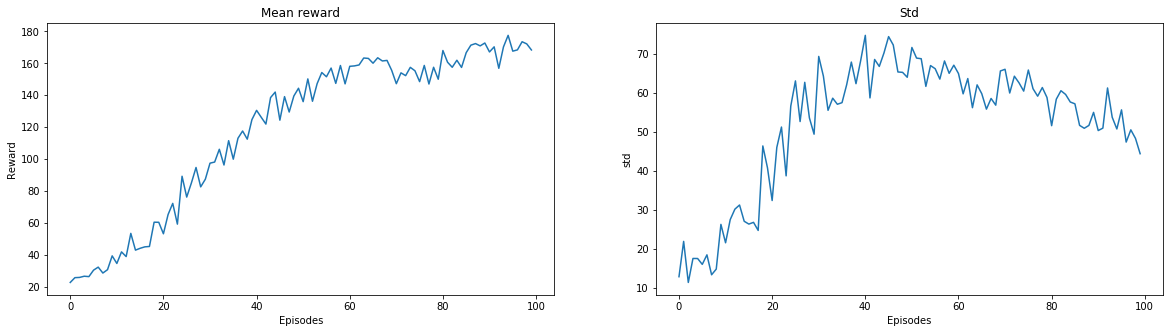

In [96]:
reward_history.plot()

In [405]:
###### learner.train(100, show_chart)
for i in range(2):
    agent.run()
# display.clear_output(wait=True)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode finished successfully after 200 timesteps
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode finished successfully after 113 timesteps


# Lessons Learnt


- Adding a baseline made all the difference. Baseline is average of all rewards at that specific time step instead of some arbitrary number or average of the episode or past episodes. 

# Mean reward over 100 training sessions

- REINFORCE
![mean reward](./images/REINFORCE.png)